<a href="https://colab.research.google.com/github/GeomaticsCaminosUPM/geodataset/blob/main/examples/vienna_transport_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vienna Transportation Dataset Tutorial

A tutorial for the creation of a semantic segmentation dataset focused on transportation infrastructure.

Colab commands for library installation.

In [1]:
#Only execute this cell if you are using google colab
!pip install geopandas
!pip install git+https://github.com/GeomaticsCaminosUPM/geodataset.git
!pip install folium matplotlib mapclassify
!pip install ipyleaflet
# After this restart the session

  Cloning https://github.com/GeomaticsCaminosUPM/geodataset.git to /tmp/pip-req-build-_1_5gzlu
  Running command git clone --filter=blob:none --quiet https://github.com/GeomaticsCaminosUPM/geodataset.git /tmp/pip-req-build-_1_5gzlu
  Resolved https://github.com/GeomaticsCaminosUPM/geodataset.git to commit bccaca01299aae49533c1320f0cf17112d16c274
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.1/240.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━

In [1]:
import geopandas as gpd

from geodataset import GeoDataset, Grid, ImageData, SegmentationData
from geodataset.grid import ipyleaflet_drawable_map
import geodataset.wms

## Dataset Bounds

Define the geographical bounds for your dataset using one of the following methods:

1. **Select on the Map**:  
   Interactively select the desired bounds directly on the map interface.

In [2]:
m, draw_features = ipyleaflet_drawable_map(center=[48.2050,16.3701], zoom=17) # center=[lat, lon]
m

Map(center=[48.205, 16.3701], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

New geometry added: POLYGON ((16.366088 48.202496, 16.366088 48.204569, 16.370605 48.204569, 16.370605 48.202496, 16.366088 48.202496))


In [3]:
dataset_bounds = draw_features()
dataset_bounds

,geometry
0,"POLYGON ((16.36609 48.2025, 16.36609 48.20457,..."


2. **Load from File**:  
   Upload a file containing a polygon that specifies the dataset bounds. Supported file formats include:
   - GeoJSON
   - Shapefile
   - KML
   - WKT

In [ ]:
#dataset_bounds = gpd.read_file("dataset_bounds.gpkg")

## Dataset Grid

The library automatically generates a grid within the dataset bounds, dividing the area into image tiles with the appropriate size for your model.

### Configuration Parameters

You can customize the grid creation with the following parameters:

- **Image Resolution**:  
  The resolution of each image tile in meters per pixel


- **Image Shape**:  
  Defines the shape of each tile in pixels (width, height)


- **Tile Overlap**:  
  Specifies the overlap between adjacent tiles, expressed as a percentage of the tile size.
  

- **Tile in Dataset**:  
  Sets the minimum percentage of each tile that must be inside the dataset bounds to be considered valid.
  - **Tip**: If your segmentation or image data do not exist outside the dataset bounds, set this parameter to `1` or enable `hide_outside=True` when creating the dataset object.




#### Notes
- The grid generation process ensures that your dataset is divided into manageable tiles, optimized for your model input.



In [4]:
img_resolution = (0.15, 0.15)  # 15 cm per pixel (width, height)
img_shape = (512, 512)  # Image shape in pixels (width, height)
tile_overlap = 0.2  # 20% overlap on each side of the grid tiles
tile_in_dataset = 0.5  # 50% of the tile has to be inside the dataset bounds

In [5]:
grid = Grid(
    dataset_bounds=dataset_bounds,  # Define the dataset bounds
    resolution=img_resolution,      # Define the image resolution (meters per pixel)
    shape=img_shape,                # Define the image shape (pixels)
    overlap=tile_overlap,                # Set the overlap between tiles
    tile_in_dataset=tile_in_dataset # Set the minimum tile coverage within bounds
)

## Images

The input data for an image segmentation geodataset consists of RGB images. These images can come from various sources and formats, which are supported by the library.


Now, let's prepare the dataset using Vienna's government-provided yearly aerial imagery, which can be accessed through a WMTS service.

In [6]:
img_url = "https://mapsneu.wien.gv.at/wmtsneu/1.0.0/WMTSCapabilities.xml"

The library provides functions under `geodataset.wms` to explore wms or wmts services.

In [7]:
geodataset.wms.print_wmts_layers(img_url)

['fmzk3dviewer',
 'lb',
 'lb2022',
 'lb2021',
 'lb2020',
 'lb2019',
 'lb2018',
 'lb2017',
 'lb2016',
 'lb2015',
 'lb2014',
 'lb1992',
 'lb1986',
 'lb1981',
 'lb1976',
 'lb1971mU',
 'lb1971',
 'lb1961',
 'lb1956',
 'lb1938',
 'fmzk',
 'flwbplmzk',
 'beschriftung']

We can take a look into the image provided by the `lb` layer which is the most recent image

In [8]:
basemap = geodataset.wms.wmts_folium_basemap(img_url,layer='lb')
m=dataset_bounds.boundary.explore(tiles=basemap)
m

Style None not found. Changed to farbe
Tilematrixset None not found. Changed to google3857_0-21


### Image provider object

The image provider object has the method handles requests and crops the image to the desired bounds and resolution.

#### Supported Input Formats and Resources

1. **Locally Saved Raster Files**  
   To load geographically referenced raster files stored locally, use the `geodataset.image.from_files()` method:
   ```python
   geodataset.image.from_files("path/to/your/image_folder")
   ```

2. **Web Map Services (WMS), Web Map Tile Services (WMTS) and XYZ tiles**  
   To load images from WMS or WMTS services, which provide tiled map datasets, use the `geodataset.image.WMS()` , `geodataset.image.WMTS()` or `geodataset.image.XYZ()` method:
   ```python
   geodataset.image.WMS("https://example.com/wms", layer="layer")
   ```
   Tools to explore WMS and WMTS providers are available under `geodataset.wms`.

3. **Custom Image Providers**  
   If you have a custom image provider, ensure it includes the following:
   - A `.get` method that accepts `bounds: gpd.GeoSeries` and returns:
     - The image as a `PIL.Image`.
     - The image bounds as a `gpd.GeoSeries` object.
   - Optional methods for added functionality:
     - `.basemap()` to plot maps by accepting bounds as an argument and returning a `folium` basemap.
     - `.save_metadata()` to save metadata alongside the dataset, if required.
```


In [14]:
img_obj = geodataset.image.WMTS(wmts=img_url,layer="lb")

Style None not found. Changed to farbe
Tilematrixset None not found. Changed to google3857_0-21
Maximum available zoom level is 21 for a max resolution of 0.07564553543474244 m per pixel


## Segmentation

In a geoimage segmentation dataset, the ground truth data consists of polygons representing objects, with each polygon assigned an ID corresponding to its semantic class.

Let's use Vienna's goverment offitial WFS service

In [9]:
anns_url = "https://data.wien.gv.at/daten/geo?version=1.1.0&service=WFS&request=GetCapabilities"

We can exmplore the layers (typename) that the WFS provides

In [10]:
geodataset.wms.print_wfs_typenames(anns_url)

['ogdwien:PLANUNGASTOGD',
 'ogdwien:SCOOTERABSTELLOGD',
 'ogdwien:ABWASSERWAERMEOGD',
 'ogdwien:ABWARMEPOTOGD',
 'ogdwien:ADRESSENOGD',
 'ogdwien:ALLESGURGELTOGD',
 'ogdwien:ALTSTOFFSAMMLUNGOGD',
 'ogdwien:AMBULANZOGD',
 'ogdwien:ENERGIEAMPELEWSOGD',
 'ogdwien:ENERGIEAMPELGWPOGD',
 'ogdwien:AKUSTISCHEAMPELOGD',
 'ogdwien:AMPELOGD',
 'ogdwien:ANLAGENLEISTUNGOGD',
 'ogdwien:PARKENANRAINEROGD',
 'ogdwien:ARCHAEOSDLGOGD',
 'ogdwien:APOTHEKEOGD',
 'ogdwien:FUNDPUNKTEOGD',
 'ogdwien:ARCHAEOSTRASSENOGD',
 'ogdwien:ARZTOGD',
 'ogdwien:AUSBLICKSPUNKTOGD',
 'ogdwien:BADESTELLENOGD',
 'ogdwien:BANKAUSTRIAOGD',
 'ogdwien:FMZKBKMOGD',
 'ogdwien:BAUMKATOGD',
 'ogdwien:GEBAEUDETYPOGD',
 'ogdwien:BEFUNDARCHAEOOGD',
 'ogdwien:BEGEGNUNGSZONEOGD',
 'ogdwien:BEHINDERTENPARKPLATZOGD',
 'ogdwien:BERATUNGSZENTROGD',
 'ogdwien:BLICKBETRACHTABOGD',
 'ogdwien:BLICKBETRACHTCOGD',
 'ogdwien:BEZIRKSGRENZEOGD',
 'ogdwien:BIOSPHPARKFOGD',
 'ogdwien:BTKARTIERUNGOGD',
 'ogdwien:BTKLBACHOGD',
 'ogdwien:SICHTBARKEITPOGD

We are interested in transport related layers: 'ogdwien:FMZKVERKEHR1OGD' and 'ogdwien:FMZKVERKEHR2OGD'


Let's explore the 'ogdwien:FMZKVERKEHR1OGD' layer and see what the wfs service returns

In [11]:
gdf = geodataset.wms.request_wfs_features(anns_url,bounds=dataset_bounds,typename='ogdwien:FMZKVERKEHR1OGD')
#If dataset_bounds is big set bounds to a smaller polygon to have a faster loading time
gdf.explore(cmap='gist_rainbow',column='LAYER')

Crs 4326 not found. Changed to 31256


By clicking on the map you can discover that the column 'F_KLASSE' contains the semantic ID and the 'LAYER' column the semantic ID name.

### Segmentation Provider Object

Multiple ground truth data formats are supported for segmentation:  

- **Polygons in Vector Format Files** (`geodataset.segmentation.Polygon()`):  
  From a file or a list of vectorial geometry files.

- **WFS Online Services** (`geodataset.segmentation.WFSPolygon()`):  
  Ground truth data can be accessed online via Web Feature Service (WFS).  

- **OSM Turbo API Requests** (`geodataset.segmentation.OSMPolygon()`):  
  Data can be fetched from OpenStreetMap (OSM) using a Turbo API request.  

- **Linestrings in Vector Format** (`geodataset.segmentation.LineString()`):  
  Linestrings that form polygons, such as those in the Madrid parking dataset example.  

- **Semantic Class Georeferenced Raster Files** (`geodataset.segmentation.from_raster_files()`):  
  Raster files containing georeferenced semantic class information.  

- **Custom Segmentation Provider:**  
  If you have a custom segmentation provider, ensure it includes the following:  
  - A `.get` method that accepts `bounds: gpd.GeoSeries` and returns:  
    - The annotations as a `gpd.GeoDataFrame` with a `semantic_class` column and `shapely.Polygon` geometries.  
    - The image bounds as a `gpd.GeoSeries` object.  
  - Optional methods for added functionality:  
    - `.geometry()`: Plots maps by accepting bounds as an argument and returning the annotations as a `gpd.GeoDataFrame` with a `semantic_class` column and `shapely.Polygon` geometries in a faster way than `.get()`.  
    - `.save_metadata()`: Saves metadata alongside the dataset, if required.  

### Output Formats for Segmentation Masks  

Segmentation masks can be generated in several formats:  

- **GeoDataFrame Annotation Format** (`ann_mode = 'geodataframe'`):  
  - One file for each image with annotations in `gpkg` format. Each insance has its own row and a `semantic_class` column.

- **COCO Annotation Format** (`ann_mode = 'coco'`):  
  - One file for the whole dataset with image paths and their annotations in a compressed format.

- **Two Raster Files per Image** (`ann_mode = 'raster'`):  
  - One raster file for semantic class (ints for semantic labels).  
  - Another raster file for instance class (ints for instance IDs).  

- **MaskFormer Format** (`ann_mode = 'maskformer'`):  
  A 3-channel png image:  
  - Channel 0: Semantic class.  
  - Channel 1: Instance class.  
  - Channel 2: Contains only zeros.  

### Important Notes  

- **Coordinate Reference System (CRS):**  
  Images and segmentation data must share the same CRS. To ensure compatibility, ground truth data is always processed in vectorial formats. It is then transformed into the CRS of the image provider and rasterized if necessary.  

- **Combining Multiple Segmentation Providers:**  
  You can create multiple segmentation provider objects and combine them when passing them to the `GeoDataset` object.  

Now, we can create our segmentation ground truth provider object.  

Since we have two different WFS layers, `'ogdwien:FMZKVERKEHR1OGD'` and `'ogdwien:FMZKVERKEHR2OGD'`, we will need to define two separate provider objects.

The `label_transform_dict` argument is used to map the IDs from the WFS service geometry to the desired semantic IDs in the dataset. For example:  

- The `'F_KLASSE'` values `27`, `28`, and `29`, which correspond to train and tram tracks, are all mapped to semantic ID `2` in the dataset.  
- IDs not included in the dictionary, such as `81` (which represents "Denkmal" and is not relevant to the dataset), are automatically assigned to the background class with ID `0`.  
- If you want to include an ID but not change its value include in the `label_transform_dict` a key and value pair like this: `{id : id}`.
- As we have `7` total classes no semantic ID should be above 7

In [12]:
seg_obj_1 = geodataset.segmentation.WFSPolygon(anns_url,typename='ogdwien:FMZKVERKEHR1OGD',semantic_class_column='F_KLASSE',
                                     label_transform_dict={21:1,26:5,27:2,28:2,29:2,30:3,32:1,33:4})

seg_obj_2 = geodataset.segmentation.WFSPolygon(anns_url,typename='ogdwien:FMZKVERKEHR2OGD',semantic_class_column='F_KLASSE',label_transform_dict={23:6, 25:7})

Crs 4326 not found. Changed to 31256
Crs 4326 not found. Changed to 31256


## Dataset object

We can now create a `GeoDataset` object by inputting the image and segmentation providers.

### Key Parameters  

- **`hide_outside=True`:**  
  - Masks pixels outside the dataset bounds with black.  
  - Removes all segmentation geometry outside the dataset bounds.  

- **`n_classes`:**  
  - Specifies the number of semantic classes in the dataset.  
  - **Important:** No semantic ID should exceed this value.  

- **`instances=True`:**  
  - If your dataset is only semantic set this to `False`.

- **Minimum Area**:  
  Sets the minimum area (in square meters) of any instance that should be included in the grid. Instances smaller than this area will be excluded.


- **Minimum Object Coverage**:  
  Specifies the minimum percentage of the object that must appear within a tile for it to be included.


- **Minimum Tile Coverage**:  
  Defines the minimum coverage of the tile that must be non-background (i.e., contains meaningful data).

  
- **Test Dataset:**  
  - You can provide only an image provider when creating a dataset for testing purposes.  

- **Segmentation Providers Order:**  
  - The order of segmentation providers in the list is **important**.  
  - Objects from segmentation providers listed later in the array will **overlay** objects from providers listed earlier.  


In [15]:
ds = GeoDataset(
    grid=grid,
    image=img_obj,
    segmentation=[seg_obj_1,seg_obj_2],
    hide_outside=True,
    n_classes=7, # Our dataset has 7 classes
    min_area=4, # Min area is 4 m2
    min_object_coverage=0.05,
    min_tile_coverage=0.05,
    instances=False #Our dataset is only semantic
)

Let's take a look at the dataset bounds and tiles

In [16]:
ds.to_map(mode='grid')

You may notice that the tiles are slightly rotated. This occurs because the tiles are initially created in a UTM CRS and then transformed to the CRS of the image.  

### Why This Happens  

- Raster files are saved using `[minx, miny, maxx, maxy]` bounding box coordinates, rather than directly using vectorial polygon geometries.  
- When these bounding box coordinates are converted to a different CRS, the resulting bounding box can appear slightly rotated.  
- Additionally, the transformed bounding box often covers a slightly larger area than the original tile due to the geometric distortion introduced by the CRS transformation.  

This is an inherent behavior of CRS transformations and how bounding boxes are represented in raster files.  


### Image, Segmentation, and Grid on a Map

We can visualize specific tiles (e.g., tiles `0`, `1`, and `2`) on a map, including their image, segmentation, and grid boundaries.  

### Important Notes  

- **Segmentation Geometries:**  
  Plotting segmentation geometries can be computationally intensive, especially for large datasets.  
  - **Tip:** Avoid plotting the entire dataset at once.  
  - Instead, provide:  
    - A **list of specific tile IDs** (e.g., `[0, 1, 2]`), or  
    - A **GeoSeries Polygon geometry** to indicate the region of the dataset to be plotted.  


In [17]:
ds.to_map([0,1,2],mode='all')

/usr/local/lib/python3.11/dist-packages/geodataset/geodataset.py:366: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  m=geometry[geometry['semantic_class'] == 0].explore(m=m,color='black',legend=False)


### Plotting one Tile

To visualize tile `0`, you can specify the `ann_mode` to define the annotation format.
This represents exactly how the tile of the dataset will look like.

The supported formats are:  

- **`coco`:** COCO annotation format.  
- **`raster`:** Two raster files (semantic and instance classes).  
- **`geodataframe`:** Geometries as a GeoDataFrame.  
- **`maskformer`:** 3-channel image format used by MaskFormer.  

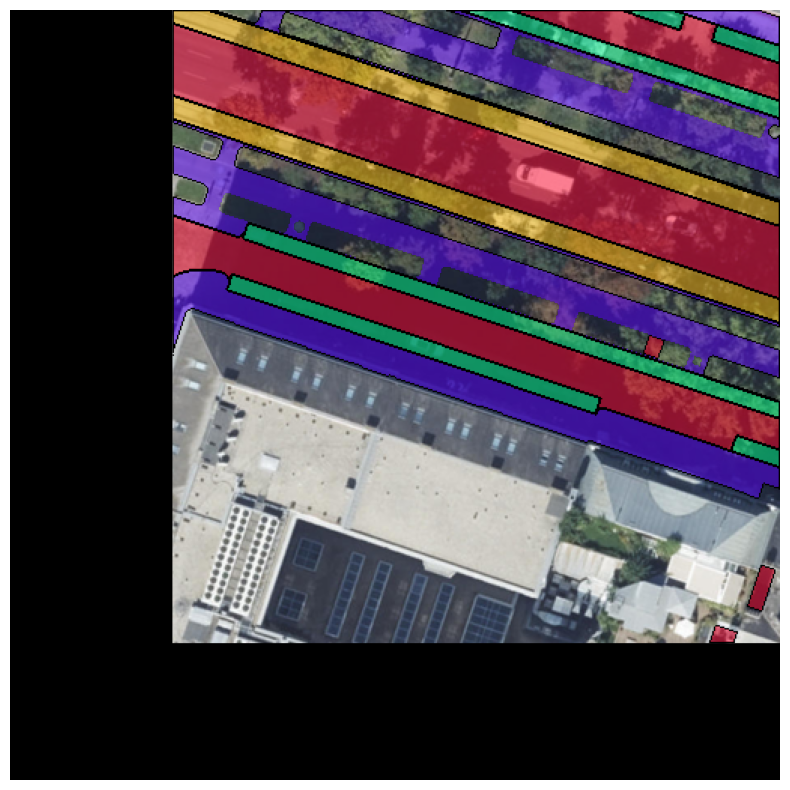

In [18]:
ds.plot(0,ann_mode='coco')

### Accessing Images and Annotations  

You can access images and annotations for a specific tile using the `get_image` and `get_annotation` methods. These methods allow you to retrieve data by:  

1. **Providing the Tile ID:**  
   - Specify the unique ID of the tile.  
2. **Providing a Polygon Geometry:**  
   - Pass a `GeoSeries` Polygon geometry to retrieve data for a specific region.  

In [19]:
img,img_bounds = ds.get_image(0)

In [20]:
coco,seg_bounds = ds.get_annotation(0,ann_mode='coco',bounds=img_bounds)

gdf,seg_bounds = ds.get_annotation(0,ann_mode='geodataframe',bounds=img_bounds)

semantic,seg_bounds = ds.get_annotation(0,ann_mode='raster',bounds=img_bounds)

maskformer,seg_bounds = ds.get_annotation(0,ann_mode='maskformer',bounds=img_bounds)

### Downloading the Dataset  

Before downloading the dataset, you need to select the tiles that you want to download. You can choose the tiles using one of the following methods:

### Methods for Selecting Tiles

1. **Select All Tiles:**

   Use `select_all_tiles()` to select every tile in the dataset.


2. **Select Random Tiles:**

   Use `select_random_tiles(n_tiles)` to randomly select a specified number of tiles (`n_tiles`).


3. **Select Tiles by ID List:**

   Use `select_tiles(tile_id_list)` to select specific tiles by their tile IDs.


4. **Select Tiles within Specific Bounds:**

   Use `select_tiles_in_bounds(bounds:gpd.GeoSeries, how='intersects' or 'contains')` to select tiles based on geographical bounds. You can specify the selection type:
   - `'intersects'`: Select tiles that intersect with the provided bounds.
   - `'contains'`: Select tiles fully contained within the provided bounds.


#### Notes  
- After selecting the tiles, use the `download()` method to save the images and annotations in the desired format.  


In [21]:
ds.select_all_tiles()

To download the entire dataset, you need to specify the **download paths** and the **annotation format**. In addition, the following parameters are available for customization:

### Parameters  

- **`img_path`:**  
  The path where the images will be saved.  

- **`anns_path`:**  
  The paths where the annotations will be saved.  

- **`ann_mode`:**  
  The annotation format (e.g., `'coco'`, `'raster'`, `'geodataframe'`, `'maskformer'`).

- **`on_errors`** (default: `'ignore'`):  
  Defines the behavior when an error occurs for an image or segmentation provider:
  - `'ignore'`: Skip the tile and continue.
  - `'raise'`: Stop processing when an error occurs and raise it.

- **`overwrite`** (default: `False`):  
  If set to `True`, any existing files will be overwritten.  

- **`allow_empty_anns`** (default: `False`):  
  Specifies whether to allow tiles with no objects in the annotations:
  - `'False'`: Skip the tile if no objects are found (recommended for training).
  - `'True'`: Save the tile even if no objects are present (useful for validation datasets).  


In [22]:
ds.download(img_path='/content/dataset/images',anns_path='/content/dataset/',ann_mode='coco',allow_empty_anns=False)

Creating image download path /content/dataset/images
Progress: [##] 100% (20/20)Grid tiles saved as /content/dataset/images/grid_tiles.geojson
Grid bounds saved as /content/dataset/images/grid_bounds.geojson
Dataset bounds saved as /content/dataset/images/dataset_bounds.geojson
Grid tiles saved as /content/dataset/grid_tiles.geojson
Grid bounds saved as /content/dataset/grid_bounds.geojson
Dataset bounds saved as /content/dataset/dataset_bounds.geojson
An error occurred saving GetCapabilities XML: 'WebFeatureService_1_1_0' object has no attribute 'getServiceXML'
wfs capabilities saved as /content/dataset/anns_metadata_0_WFSCapabilities.xml
An error occurred saving GetCapabilities XML: 'WebFeatureService_1_1_0' object has no attribute 'getServiceXML'
wfs capabilities saved as /content/dataset/anns_metadata_1_WFSCapabilities.xml
